# 0. DATASET 준비

이번 과제는 전세계에서 가장 큰 인공지능 오픈소스 커뮤니티인 hugging face의 dataset을 기반으로 학습을 진행해볼 것이기 때문에, hugging face에서 제공하는 datasets 라이브러리를 통해 간편하게 받아올 수 있다.

In [9]:
!pip install datasets

# 1. DATA 전처리 및 DATACLASS 정의

DATA를 로드한 후 다루기 쉽게 pandas의 DATAFRAME 형태로 변경한 뒤, 해당 데이터를 train : val : test = 0.8 : 0.1 : 0.1 로 나눠준다. 더불어 DATASET 클래스를 정의하고, DATALOADER에서 불러올 수 있도록 한다.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

# Dataset loading and processing
from datasets import load_dataset

# Load the dataset from Hugging Face
eth_data = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")

df = pd.DataFrame(eth_data['train'])

data_inputs = np.array(df['input_ids'].to_list())
labels = np.array(df['label'].values)

# Define hyperparameters
sequence_length = 50
batch_size = 32
epochs = 150
learning_rate = 0.001
hidden_size = 64


# Create dataset and DataLoader
train_size = int(len(data_inputs) * 0.8)
train_data = data_inputs[:train_size]
train_labels = labels[:train_size]

# train_data = (train_data - np.mean(train_data)) / np.std(train_data)
# trian_labels = (train_labels - np.mean(train_labels)) / np.std(train_labels)

test_data = data_inputs[train_size:]
test_labels = labels[train_size:]

# test_data = (test_data - np.mean(test_data)) / np.std(test_data)
# test_labels = (test_labels - np.mean(test_labels)) / np.std(test_labels)

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [12]:
train_dataset = TimeSeriesDataset(train_data, train_labels)
test_dataset = TimeSeriesDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        print(x_batch.unsqueeze(-1).shape)
        print(x_batch.shape, y_batch.shape)
        break

torch.Size([32, 256, 1])
torch.Size([32, 256]) torch.Size([32])


# 2. 모델 정의

총 3가지의 모델을 정의할 것인데, LSTM, RNN, GRU 이다. 세모델 모두 시계열 정보를 표현하기 위해서 사용되며, LSTM과 GRU 는 RNN의 확장판으로 longterm dependency를 보완하기 위해 gate가 추가된 형태의 모델들이다.

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out


In [15]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

# 3. 모델 학습
이전 다른 모든 과제들과 동일하게 학습 코드를 작성했으며, 매 epoch 당 train, test accuracy를 구하도록 구성했다.

Training RNN model...
Epoch 1/150, Train Loss: 1579.6986, Test Loss: 5229.3249
Epoch 2/150, Train Loss: 1458.3036, Test Loss: 5031.3942
Epoch 3/150, Train Loss: 1347.5934, Test Loss: 4795.8609
Epoch 4/150, Train Loss: 1262.7355, Test Loss: 4610.2062
Epoch 5/150, Train Loss: 1189.5648, Test Loss: 4453.9587
Epoch 6/150, Train Loss: 1125.5056, Test Loss: 4307.5049
Epoch 7/150, Train Loss: 1061.2652, Test Loss: 4167.3279
Epoch 8/150, Train Loss: 1002.2608, Test Loss: 4031.8334
Epoch 9/150, Train Loss: 947.1406, Test Loss: 3903.8603
Epoch 10/150, Train Loss: 897.4433, Test Loss: 3780.0753
Epoch 11/150, Train Loss: 847.7368, Test Loss: 3660.3444
Epoch 12/150, Train Loss: 804.2970, Test Loss: 3547.3972
Epoch 13/150, Train Loss: 764.7528, Test Loss: 3442.2159
Epoch 14/150, Train Loss: 723.5269, Test Loss: 3335.5025
Epoch 15/150, Train Loss: 687.7630, Test Loss: 3235.4584
Epoch 16/150, Train Loss: 652.8901, Test Loss: 3141.0462
Epoch 17/150, Train Loss: 622.1579, Test Loss: 3051.4421
Epoch 18/1

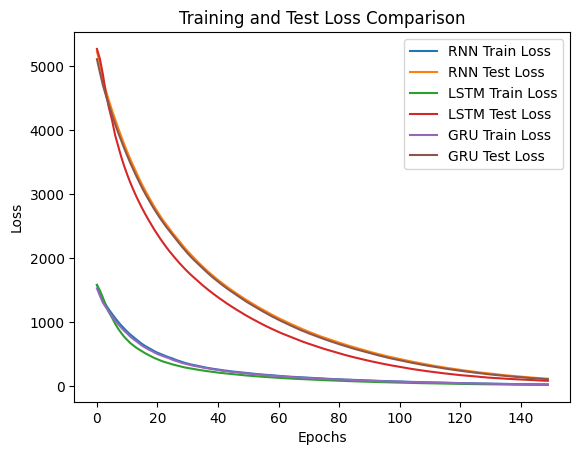

In [16]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        predictions = model(x_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)


def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            predictions = model(x_batch).squeeze()
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    return total_loss / len(test_loader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "RNN": RNNModel(1, hidden_size).to(device),
    "LSTM": LSTMModel(1, hidden_size).to(device),
    "GRU": GRUModel(1, hidden_size).to(device)
}

criterion = nn.MSELoss()
results = {}

for model_name, model in models.items():
    print(f"Training {model_name} model...")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        test_loss = evaluate_model(model, test_loader, criterion, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    results[model_name] = (train_losses, test_losses)

    plt.plot(train_losses, label=f'{model_name} Train Loss')
    plt.plot(test_losses, label=f'{model_name} Test Loss')

plt.title('Training and Test Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 4. 분석 및 고찰

## **ETH-USD 시계열 데이터**

이 코드에서 사용하는 데이터셋은 Hugging Face의 "StockLlama/ETH-USD-2022-01-01_2024-08-30" 데이터셋으로, 2022년 1월 1일부터 2024년 8월 30일까지의 이더리움(ETH)과 미국 달러(USD) 환율 데이터를 포함하고 있습니다.

이 데이터셋은 train이라는 단일 데이터 스플릿으로 제공되며, 종가, 최고가, 최저가, 장마감 등의 주식에서 볼 수 있는 값들을 column으로 가지고 있으며, 주요 task는 다음 시점의 값을 예측하는 것입니다.

### **데이터셋 활용 방식**
- 데이터는 총 716개로 구성되어 있습니다.
- train : test 데이터가 따로 나누어져 있지 않으며, 임의로 0.8 : 0.1 : 0.1 비율로 구성하여 사용하였습니다.
- 시간 정보는 따로 제공되지 않으며, 단순히 값이 나열되어 있습니다.

---

## **결과에 대한 고찰**

모델에 상관없이, 다행히도 epoch이 늘어남에 따라 train loss와 test loss가 잘 감소하는 것을 볼 수 있었습니다. 그러나 Test Loss의 경우, 예상과 달라 상당히 놀랐습니다. 예상은 LSTM → GRU → RNN 순으로 test loss가 나올 것이라고 생각했으나, 실제 결과는 그렇지 않았습니다. 그 이유에 대해 분석해보고자 합니다.

### **TEST LOSS 결과**
- **RNN**: 104.2288
- **LSTM**: 91.5012
- **GRU**: 107.9035

### **분석**
1. **Dataset이 작아 long-term dependency가 발생하지 않았다.**
   - 데이터셋은 총 716개로, 그 중에서도 50개를 보고 51번째 값을 예측하도록 설정했습니다. 이 길이가 너무 짧아 GRU와 LSTM의 구조가 RNN에 비해 그리 효과적이지 않았을 수 있습니다.

2. **Dataset이 일관적인 경향성을 띄고 있다.**
   - 만약 데이터가 시계열 데이터가 아닌 문자열 데이터였다면, 그 관계성이 비교적 모호해 학습이 덜 되었을 수 있습니다. 하지만 ETH 값에 대한 데이터는 비교적 예측이 가능했던 것으로 보입니다.

3. **Epoch 수가 부족했다.**
   - Loss가 떨어지는 모습을 보면 초기보다 감소해 local minima에 빠진 것처럼 보이지만, 각 값이 여전히 떨어지고 있다는 점에서 더 많은 epoch을 통해 학습이 진행되면, 더 극명한 성능 차이를 알 수 있을 것 같습니다.

---
